# Walk-Forward Analysis with Hidden Markov Models

This notebook builds a complete walk-forward backtesting engine for a Market Regime-Switching strategy.

We start from the core GMM-HMM model (Gaussian Mixture Model - Hidden Markov Model) explored in `hmm_model.py` and extend it to a rolling-window framework to realistically simulate historical performance.

## Chapter 1: Data Gathering & Initialization

Our first step is to configure the environment, load the financial data, and inspect it to ensure it is suitable for a long-term walk-forward analysis.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from stock import Stock
from typing import Tuple, List, Dict, Optional

### 1.1 Configuration

We select the asset and the time frequency. For a robust walk-forward test, we need a long history of data. 
We also define the `TRAINING_WINDOW`, which determines how much past data the model 'sees' at each step to learn the regimes.

In [ ]:
TICKER = 'AAPL'            # Asset to backtest
TIME_FREQUENCY = 'weekly'  # 'daily' or 'weekly'

# How many periods of history to use for training the HMM at each iteration
if TIME_FREQUENCY == 'weekly':
    TRAINING_WINDOW = 500
else:
    TRAINING_WINDOW = 1000

print(f"Configuration: {TICKER} [{TIME_FREQUENCY}]")
print(f"Rolling Window Size: {TRAINING_WINDOW} periods")

Configuration: AAPL [weekly]
Rolling Window Size: 500 periods


### 1.2 Data Loading

We use the project's `Stock` class to fetch data from Yahoo Finance. We ensure we have enough history to support both the initial training window and a significant out-of-sample testing period.

In [ ]:
# Initialize and load data
my_stock = Stock(TICKER, TIME_FREQUENCY)
my_stock.load_data(start_date='1990-01-01')     # Date format: YYYY-MM-DD

# Extract key series
df = my_stock.get_data()
prices = df['Close']
log_returns = df['Log_Returns'].dropna()

print(f"Data Loaded: {len(log_returns)} observations")
print(f"Date Range: {log_returns.index[0].date()} to {log_returns.index[-1].date()}")

From AAPL dataset were removed 7 rows with missing or incorrect data
Ticker: AAPL has 1 anomalies:
  Open-pClose Anomalies: 1

Weekly data loaded from 1990-01-05 to 2026-02-20
Total weeks loaded: 1886
Data Loaded: 1885 observations
Date Range: 1990-01-12 to 2026-02-20


### 1.3 Visual Data Inspection

Before we proceed to modeling, we visualize the full history. 
1. **Price History (Log Scale)**: Verifies the long-term trend and data quality.
2. **Returns Distribution**: Confirms the non-Normal characteristics (fat tails) that justify using an HMM.

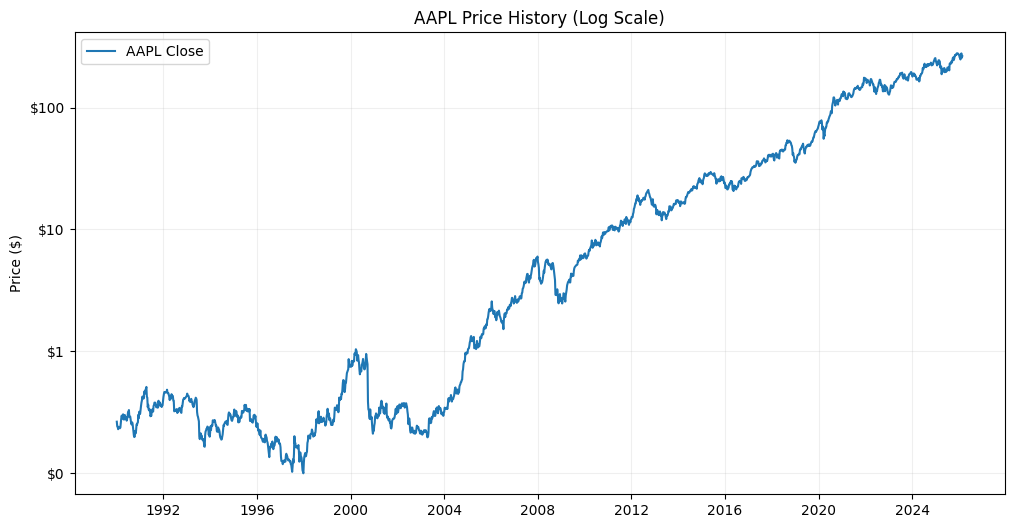

In [ ]:
# Visualize Price History
plt.figure(figsize=(12, 6))
plt.semilogy(prices.index, prices.values, label=f'{TICKER} Close')
plt.title(f"{TICKER} Price History (Log Scale)")
plt.ylabel("Price ($)")
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'${y:.0f}'))
ax.minorticks_off()  # Remove minor tick marks
plt.grid(True, which="major", ls="-", alpha=0.2)
plt.legend()
plt.show()

### Empirical Distribution Analysis

Here we visually examine the distribution of log-returns. The red line represents a standard Normal distribution fitted to the data.
Note the discrepancies: the empirical data has generally a higher peak and much wider "tails" (extreme values) than the Normal curve predicts.
This motivates using a **Mixture Model** (combination of Gaussians) rather than a simple Gaussian distribution.

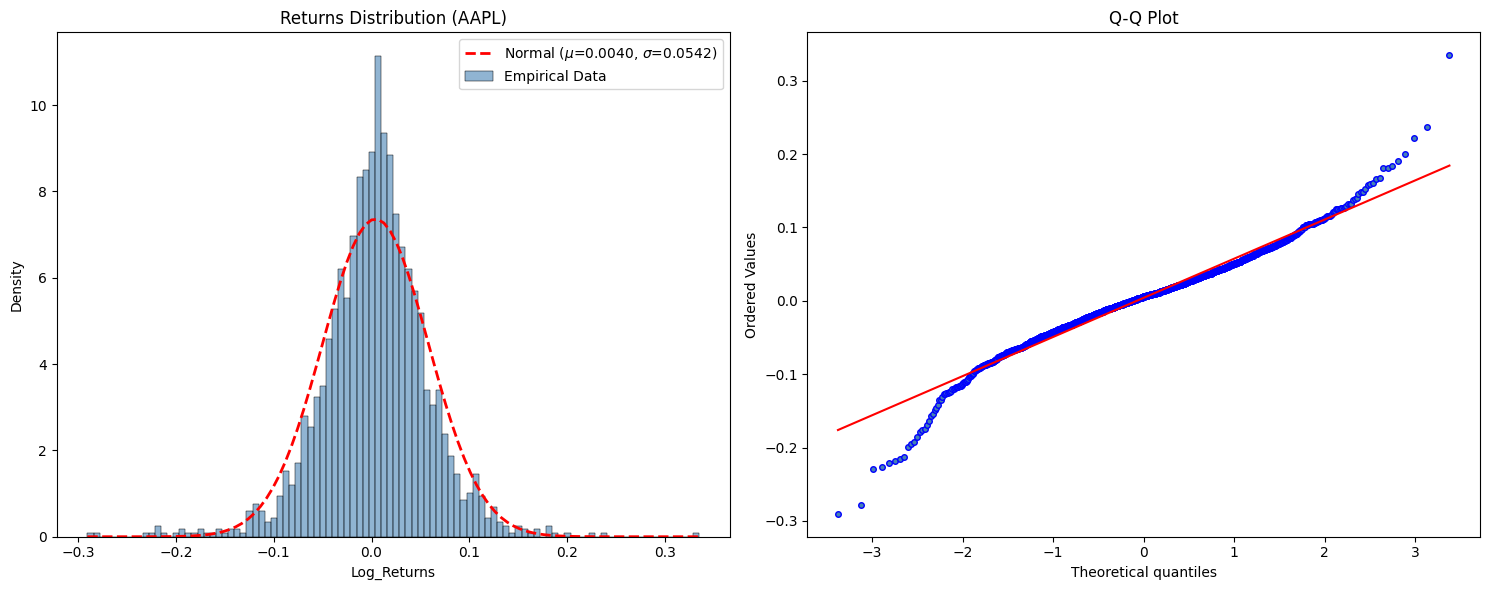

Data Check: 1885 obs. Sufficient for 1385 Out-of-Sample predictions.


In [ ]:
def remove_outliers(data: pd.Series, multiplier: int = 4):
    """
    Filter out extreme outliers for cleaner visualization (using IQR method).
    This helps in seeing the main body of the distribution without the graph being distorted by 1-2 extreme crashes.
    """
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return data[(data >= Q1 - multiplier * IQR) & (data <= Q3 + multiplier * IQR)]

# Filter the returns from outliers ONLY for a better visualization
filtered_returns = remove_outliers(log_returns, multiplier=5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Histogram vs Normal
sns.histplot(filtered_returns, bins=100, stat='density', alpha=0.6, color='steelblue', label='Empirical Data', ax=ax1)
x_range = np.linspace(filtered_returns.min(), filtered_returns.max(), 100)
stats_mu, stats_sigma = filtered_returns.mean(), filtered_returns.std()
ax1.plot(x_range, stats.norm.pdf(x_range, stats_mu, stats_sigma), 
        'r--', lw=2, label=f'Normal ($\mu$={stats_mu:.4f}, $\sigma$={stats_sigma:.4f})')
ax1.set_title(f'Returns Distribution ({TICKER})')
ax1.legend()

# Q-Q Plot
# Deviations from the red line indicate non-normality (fat tails)
stats.probplot(filtered_returns, dist="norm", plot=ax2)
ax2.get_lines()[0].set_markerfacecolor('steelblue')
ax2.get_lines()[0].set_markersize(4)
ax2.set_title('Q-Q Plot')

plt.tight_layout()
plt.show()

# Quick sanity check for Walk-Forward
total_observations = len(log_returns)
max_cycles = total_observations - TRAINING_WINDOW
if max_cycles <= 0:
    raise ValueError(f"Insufficient data. Need > {TRAINING_WINDOW} periods, but have {total_observations}.")
    
print(f"Data Check: {total_observations} obs. Sufficient for {max_cycles} Out-of-Sample predictions.")

## Chapter 2: The Identification Problem & Economic Sorting

### The Theoretical Challenge: Label Switching

In finite mixture models and Hidden Markov Models, we encounter the **Identification Problem** (often referred to as "Label Switching").
The Likelihood function of the model is invariant to the permutation of the latent states.
This means that if we simply swap the parameters of "State 0" and "State 1" (e.g., exchange their means, variances, and transition probabilities), the model explains the data equally well. The statistical algorithm has no intrinsic concept that "State 0" should represent a Bear market and "State 1" a Bull market.

In the context of a **Walk-Forward (Rolling Window) Analysis**, this is critical.
*   **Window $T$**: The model might identify "State 0" as the Low-Volatility regime and "State 1" as High-Volatility.
*   **Window $T+1$**: The numerical optimization might swap these, identifying "State 0" as High-Volatility.

Without correction, concatenating the state predictions across windows results in an incoherent time series, rendering the backtest invalid.

### Solution: Imposing a Statistical Ordering

To resolve this, we must strictly order the states based on an invariant economic metric—a **Utility Function** $U(\cdot)$—such that for our sorted states:
$$ U(\text{State}_0) < U(\text{State}_1) < \dots < U(\text{State}_{K-1}) $$

We define this function to sort regimes from "Worst" (Bear/Crash) to "Best" (Bull/Stable).

**Why Mean-Variance is usually enough**:
A standard **Mean-Variance** utility is a robust and effective way to distinguish regimes. High returns and low volatility clearly indicate a "Bull" state, while negative returns and high volatility indicate a "Bear" state.

However, adding **Skewness** and **Kurtosis** to the objective function can provide an extra layer of precision. This helps specifically in "close calls"—for example, distinguishing between a volatile recovery (high vol, positive skew) and a volatile crash (high vol, negative skew).

We use a **Higher-Moment Utility Proxy**:

$$ U(s) = \mu_s - \frac{1}{2}\sigma_s^2 + \lambda_1 \cdot \text{Skew}_s - \lambda_2 \cdot \text{Kurt}_s $$

*   **$\mu_s, \sigma_s^2$**: The aggregated mean and variance of the Gaussian Mixture for state $s$.
*   **$\text{Skew}_s$**: Captures asymmetry (Crash Risk).
*   **$\text{Kurt}_s$**: Captures tail thickness (Fat Tails).

In [ ]:
from hmmlearn.hmm import GMMHMM

def calculate_state_moments(model: GMMHMM, state_idx: int) -> Dict[str, float]:
    """
    Calculates the first four moments (Mean, Variance, Skewness, Kurtosis) 
    for a specific state's Gaussian Mixture distribution.

    This function aggregates the parameters of the component Gaussians within a state 
    using the Law of Total Cumulants/Moments.

    :param model: The trained Hidden Markov Model.
    :param state_idx: The index of the hidden state to analyze.

    :return: A dictionary containing:
        - 'mean': Aggregated expected return.
        - 'var': Aggregated variance.
        - 'skew': Fisher-Pearson coefficient of skewness.
        - 'kurt': Excess kurtosis.
    """
    # 1. Extract mixture parameters for the specific state
    weights = model.weights_[state_idx]
    means = model.means_[state_idx].flatten()
    
    # Handle covariance types
    if model.covariance_type == 'tied':
        # One shared covariance matrix for all states/components
        covs = np.full(len(weights), model.covars_[state_idx][0][0])
    elif model.covariance_type == 'diag':
        # Diagonal covariance per component
        covs = model.covars_[state_idx].flatten()
    else:
        # Full covariance, extracting diagonal elements for 1D approximation
        covs = model.covars_[state_idx].flatten()

    # 2. Aggregated Mean: E[X]
    # Simple weighted sum of component means
    agg_mean = np.sum(weights * means)

    # 3. Aggregated Variance: Law of Total Variance
    # Var(X) = E[Var(X|Z)] + Var(E[X|Z])
    #        = sum(w * sigma^2) + sum(w * (mu - agg_mean)^2)
    agg_var = np.sum(weights * covs) + np.sum(weights * (means - agg_mean)**2)
    
    # Numerical stability check
    if agg_var < 1e-12:
        return {'mean': agg_mean, 'var': 0.0, 'skew': 0.0, 'kurt': 0.0}
    
    # 4. Higher Moments via Central Moments
    # Deviation of component means from aggregate mean
    d = means - agg_mean
    
    # 3rd Central Moment (Skewness numerator): E[(X - mu)^3]
    # approx: sum(w * (d^3 + 3*d*sigma^2))
    m3 = np.sum(weights * (d**3 + 3 * d * covs))
    
    # 4th Central Moment (Kurtosis numerator): E[(X - mu)^4]
    # approx: sum(w * (d^4 + 6*d^2*sigma^2 + 3*sigma^4))
    m4 = np.sum(weights * (d**4 + 6 * (d**2) * covs + 3 * (covs**2)))
    
    # Standardize
    skew = m3 / (agg_var ** 1.5)
    kurt = (m4 / (agg_var ** 2)) - 3.0  # Excess kurtosis

    return {
        'mean': agg_mean,
        'var': agg_var,
        'skew': skew,
        'kurt': kurt
    }

def get_utility_score(
    moments: Dict[str, float], 
    skew_weight: float = 0.5, 
    kurt_weight: float = 0.1
) -> float:
    """
    Computes a risk-adjusted utility score from distributional moments.
    
    Score = Mean - 0.5 * Variance + Skew_Penalty - Kurt_Penalty

    :param moments: Dictionary with 'mean', 'var', 'skew', 'kurt'.
    :param skew_weight: Weight for skewness preference. Positive value rewards positive skew.
    :param kurt_weight: Weight for kurtosis penalty. Positive value penalizes fat tails.

    :return: The computed utility score.
    """
    # 1. Mean-Variance Base (Certainty Equivalent approximation)
    score = moments['mean'] - 0.5 * moments['var']
    
    # 2. Skewness Adjustment
    # We penalize negative skewness (crash risk). 
    # If skew is positive, we add to score. If negative, we subtract.
    score += skew_weight * moments['skew']
    
    # 3. Kurtosis Adjustment
    # We penalize excess kurtosis (uncertainty/fat tails).
    # Higher kurtosis reduces the score.
    score -= kurt_weight * moments['kurt']
    
    return score

def sort_states_by_utility(
    model: GMMHMM, 
    skew_weight: float = 0.10, 
    kurt_weight: float = 0.10
) -> np.ndarray:
    """
    Determines the sorting permutation that ranks states from Lowest Utility to Highest Utility.

    :param model: The trained HMM model.
    :param skew_weight: Importance of skewness in utility.
    :param kurt_weight: Importance of kurtosis in utility.

    :return: An array of indices representing the sorted order.
            e.g. [2, 0, 1] means State 2 is Worst, State 0 is Neutral, State 1 is Best.
    """
    n_states = model.n_components
    scores = []
    
    for s in range(n_states):
        moments = calculate_state_moments(model, s)
        u = get_utility_score(moments, skew_weight, kurt_weight)
        scores.append(u)
        
    # Return indices that sort the scores in ascending order
    return np.argsort(scores)

def apply_state_permutation(model: GMMHMM, perm: np.ndarray) -> None:
    """
    Reorders the internal parameters of the GMMHMM model in-place according to a permutation.
    
    This ensures that 'State 0' always corresponds to the first index in 'perm',
    'State 1' to the second, etc.

    :param model: The model to modify.
    :param perm: The new order of states (e.g. [2, 0, 1]).
    """
    if np.all(perm == np.arange(len(perm))): 
        return

    # 1. Reorder Initial Probabilities (startprob_)
    model.startprob_ = model.startprob_[perm]

    # 2. Reorder Transition Matrix (transmat_)
    # We must reorder both rows (from_state) and columns (to_state)
    model.transmat_ = model.transmat_[perm][:, perm]

    # 3. Reorder Emission Parameters (weights, means, covars)
    # These have shape (n_comp, n_mix, ...) so we just reorder the first axis
    model.weights_ = model.weights_[perm]
    model.means_ = model.means_[perm]
    model.covars_ = model.covars_[perm]

## Chapter 3: The Rolling Window Simulation (Walk-Forward)

Now we implement the core of our backtesting engine: the **Rolling Window Simulation**.

### The Algorithm

We iterate through time, simulating a real-world trading environment where we only have access to information available up to "today" ($t$).

For each time step $t$ in our out-of-sample period:
1.  **Define Window**: Select the historical data from $t - \text{window\_size}$ to $t$.
2.  **Preprocess**: Standardize the data (Mean=0, Std=1) based *only* on this window.
3.  **Train**: Fit the GMM-HMM model using the EM algorithm.
4.  **Sort States**: Apply our Utility Scoring function to identify which state is "Bear" (0), "Neutral" (1), Bull (2), etc.
5.  **Predict**:
    *   Compute the current state belief $P(S_t | X_{1:t})$.
    *   Forecast the state probabilities for the next period: $P(S_{t+1}) = P(S_t) \times \mathbf{T}$.
6.  **Store**: Record the date, the forecast probabilities, and (later) the realized return for analysis.

### Computational Note
This process involves re-training a complex probabilistic model hundreds of times. This can be computationally intensive at scale.
To ensure robustness, we use a fresh initialization for each window (no "warm start" for now) to avoid getting stuck in local optima from previous regimes, although this increases variance slightly.

In [ ]:
from sklearn.preprocessing import StandardScaler
import time

# Simulation Parameters
N_STATES = 3           # 3 States: Bear, Neutral, Bull
N_MIXTURES = 3         # 2/3 Gaussian components per state to capture non-normality
ITERATIONS = 150       # Max EM iterations per window
REPEATS = 5            # Number of random initializations to run at EACH iteration (default: 1). Best result (highest likelihood) is kept. 
                       # Increasing this (e.g., to 5) reduces the risk of local optima but linearly increases runtime.

### Model Complexity Analysis

Free Parameters Count for GMM-HMM (1D data):

* Start Probabilities ($\pi$): $N - 1$
* Transition Matrix ($A$): $N \times (N - 1)$ [Rows sum to 1]
* Mixture Weights ($w$): $N \times (M - 1)$ [Weights sum to 1 per state]
* Means ($\mu$): $N \times M$ [1 mean per component]
* Covariances ($\Sigma$): $N$ [1 var per state if 'tied']

Calculation for N=3, M=3, Cov='tied':
Free Params = $2 + 6 + 6 + 9 + 3 = 26$ parameters.

Data Sufficiency:
* Data-to-Parameter Ratio (weekly): $500 / 26 \approx 19.2$
* Rule of Thumb: We generally want > 10 observations per parameter.

In [ ]:
n_params = (N_STATES - 1) + (N_STATES * (N_STATES - 1)) + \
           (N_STATES * (N_MIXTURES - 1)) + (N_STATES * N_MIXTURES) + \
           (N_STATES if 'tied' == 'tied' else N_STATES * N_MIXTURES)

print(f"Model Complexity Check:")
print(f"  States (N): {N_STATES}")
print(f"  Mixtures (M): {N_MIXTURES}")
print(f"  Estimated Parameters: {n_params} free parameters")
print(f"  Observations per Window: {TRAINING_WINDOW}")
print(f"  Obs/Param Ratio: {TRAINING_WINDOW / n_params:.1f} (Target > 10)")

Model Complexity Check:
  States (N): 3
  Mixtures (M): 3
  Estimated Parameters: 26 free parameters
  Observations per Window: 500
  Obs/Param Ratio: 19.2 (Target > 10)


## Walk-Forward Simulation

In [ ]:
# 1. Setup the Simulation Loop
# We predict from the end of the first window until the end of the dataset
n_observations = len(log_returns)
start_index = TRAINING_WINDOW
end_index = n_observations

print("=" * 50)
print(f"Starting Walk-Forward Simulation...")
print(f"  Range: {start_index} to {end_index}")
print(f"  Total Steps: {end_index - start_index}")
print("=" * 50)
print("")

# Store results
results = []
start_time = time.time()

# 2. Main Loop
for t in range(start_index, end_index):
    # --- A. Data Preparation ---
    train_slice = log_returns.iloc[t - TRAINING_WINDOW : t]
    
    # We need to reshape for hmmlearn: (n_samples, n_features)
    X_train = train_slice.values.reshape(-1, 1)
    
    # Input Standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # --- B. Model Training ---
    # We iterate REPEATS times each iteration to find the best initialization (highest likelihood)
    # This is done to avoid local optima
    best_model = None
    best_score = -float('inf')

    for rep in range(REPEATS):
        # Generate a unique seed for this specific run:
        # Base: 50
        # + t: Changes every time step (so window T is different from window T+1)
        # + rep*10000: Changes every repeat (so Attempt 1 is different from Attempt 2)
        current_random_state = 50 + t + (rep * 10000)

        # Initialize GMM-HMM
        candidate_model = GMMHMM(
            n_components=N_STATES,
            n_mix=N_MIXTURES,
            covariance_type='tied',
            min_covar=0.01,        # Regularization parameter 
            n_iter=ITERATIONS,
            tol=1e-3,
            random_state=current_random_state,  
            init_params='stmcw',
        )
        
        try:
            candidate_model.fit(X_train_scaled)
            
            # Fix potential zero-sum rows in transmat_ (caused by unobserved states)
            row_sums = candidate_model.transmat_.sum(axis=1)
            for i in range(candidate_model.n_components):
                if np.isclose(row_sums[i], 0.0):
                    print(f"WARNING (t={t}): State {i} unobserved (EM assigned 0 prob). Forced uniform transitions.")
                    print("  -> Root case: Window too small or too many states. Consider increasing TRAINING_WINDOW or reducing N_STATES.")
                    candidate_model.transmat_[i, :] = 1.0 / candidate_model.n_components
            
            # Check score (Log Likelihood)
            # The monitor_.history stores the log likelihoods of iterations. The last one is the converged value.
            score = candidate_model.monitor_.history[-1]
            
            if score > best_score:
                best_score = score
                best_model = candidate_model
                
        except Exception as e:
            print(f"Convergence failure at step {t}: {e}")
            continue

    # Assign the best model found
    if best_model is None:
        print(f"Convergence failure at step {t}: Could not fit any model in {REPEATS} repeats.")
        continue
        
    model = best_model

    # --- C. Identification & Sorting ---
    # Solve the Label Switching problem using our Utility Function
    # NB: The weights for skewness and kurtosis determine the relative importance of 
    #     these metrics in the sorting process. 
    # Note: Moments are calculated on Standardized Data (Mean~0, Var~1). Weights must be consistent with this.
    ordering = sort_states_by_utility(model, skew_weight=0.2, kurt_weight=0.1)
    apply_state_permutation(model, ordering)
    
    # --- D. Prediction (One-Step Ahead) ---
    # 1. Get filtered state probability for "Today" (time t-1 relative to window end)
    # score_samples returns smoothed probabilities. For the last point, smoothed = filtered.
    _, posterior_probs = model.score_samples(X_train_scaled)
    # The last element corresponds to the state belief for the most recent observation in the train/window
    current_state_belief = posterior_probs[-1] 
    
    # 2. Forecast "Today" (index t) by applying the Transition Matrix once
    #    P(S_t) = P(S_{t-1}) * TransitionMatrix
    next_state_probs = current_state_belief @ model.transmat_
    
    # --- E. Record Results ---
    # 'target_date' is the date of the return we are trying to predict (index t)
    target_date = log_returns.index[t]
    actual_return = log_returns.iloc[t]
    
    record = {
        'Date': target_date,
        'Actual_Return': actual_return,
        # Predicted State (Where will we be TOMORROW?)
        'Pred_State_0': next_state_probs[0], # Bear (lowest utility)
        'Pred_State_1': next_state_probs[1], # Neutral
        'Pred_State_2': next_state_probs[2], # Bull (highest utility)
        
        # Current Belief (Where are we TODAY?)
        'Belief_State_0': current_state_belief[0],
        'Belief_State_1': current_state_belief[1],
        'Belief_State_2': current_state_belief[2],
        
        # Transition Matrix (Dynamics)
        # We save the diagonal to measure "Regime Persistence" (Stickiness).
        'Trans_00': model.transmat_[0, 0], # Prob(Bear -> Bear)
        'Trans_11': model.transmat_[1, 1], # Prob(Neutral -> Neutral)
        'Trans_22': model.transmat_[2, 2], # Prob(Bull -> Bull)
    }
    
    # Calculate a simple "Expected Mean" for the predicted state
    pred_mean_scaled = 0
    for s in range(N_STATES):
        state_stats = calculate_state_moments(model, s)
        pred_mean_scaled += next_state_probs[s] * state_stats['mean']
        
        # Store Regime Moments (Key for validating the sorting!)
        record[f'Mu_State_{s}'] = state_stats['mean'] * scaler.scale_[0] + scaler.mean_[0] # Destandardize
        record[f'Vol_State_{s}'] = np.sqrt(state_stats['var']) * scaler.scale_[0]          # Destandardize
        record[f'Skew_State_{s}'] = state_stats['skew']
        record[f'Kurt_State_{s}'] = state_stats['kurt']
        
    # Add convergence status
    record['Converged'] = model.monitor_.converged
        
    # Destandardize prediction
    pred_mean = pred_mean_scaled * scaler.scale_[0] + scaler.mean_[0]
    record['Pred_Mean'] = pred_mean
    
    results.append(record)
    
    # Progress Bar every 10 steps
    steps_done = t - start_index + 1
    if steps_done % 10 == 0 or steps_done == (end_index - start_index):
        elapsed = time.time() - start_time
        # avoid division by zero
        if elapsed > 1e-9:
            rate = steps_done / elapsed
            remaining = (end_index - start_index - steps_done) / rate
        else:
            rate = 0
            remaining = 0
        print(f"\rStep {steps_done}/{end_index - start_index} | Speed: {rate:.1f} win/s | ETA: {remaining:.0f}s", end='')

print("\n" + "=" * 50)
print(f"Simulation Complete! Processed {len(results)} periods.")
print("=" * 50)

In [ ]:
# Convert results to DataFrame for Analysis
results_df = pd.DataFrame(results)
results_df.set_index('Date', inplace=True)

print("\n" + "="*40)
print("      WALK-FORWARD SIMULATION SUMMARY")
print("="*40)

# Convergence Rate
print(f"Convergence Rate: {results_df['Converged'].mean():.1%}")

# State Dominance Frequency (based on Current Belief)
belief_cols = [f'Belief_State_{s}' for s in range(N_STATES)]
dominant_states = results_df[belief_cols].idxmax(axis=1).apply(lambda x: int(x.split('_')[-1]))
state_counts = dominant_states.value_counts(normalize=True).sort_index()

print("\nRegime Statistics (Average over all windows):")
print(f"{'State':<6} | {'Freq':<6} | {'AvgDur':<6} | {'Return':<8} | {'Vol':<8} | {'Skew':<6} | {'Kurt':<6}")
print("-" * 65)

for s in range(N_STATES):
    freq = state_counts.get(s, 0.0)
    
    # Calculate Average Duration: 1 / (1 - p_ii)
    trans_col = f'Trans_{s}{s}'
    avg_trans_prob = results_df[trans_col].mean()
    # Avoid division by zero if prob is exactly 1.0
    avg_duration = 1.0 / (1.0 - avg_trans_prob) if avg_trans_prob < 0.999 else 0.0
    
    mu = results_df[f'Mu_State_{s}'].mean()
    vol = results_df[f'Vol_State_{s}'].mean()
    skew = results_df[f'Skew_State_{s}'].mean()
    kurt = results_df[f'Kurt_State_{s}'].mean()
    
    print(f"{s:<6} | {freq:.1%} | {avg_duration:<6.1f} | {mu:.4f}   | {vol:.4f}   | {skew:.2f} | {kurt:.2f}")
print("-" * 65)


      WALK-FORWARD SIMULATION SUMMARY
Convergence Rate: 100.0%

Regime Statistics (Average over all windows):
State  | Freq   | AvgDur | Return   | Vol      | Skew   | Kurt  
-----------------------------------------------------------------
0      | 10.1% | 2.0    | -0.0518   | 0.0852   | -1.72 | 6.62
1      | 46.4% | 2.8    | -0.0002   | 0.0546   | 0.10 | 0.53
2      | 43.5% | 2.2    | 0.0318   | 0.0414   | 0.29 | 0.54
-----------------------------------------------------------------


## Chapter 4: Walk-Forward Analysis & Validation

Now that we have completed the walk-forward simulation, we need to analyze the results.
In particular, we will evaluate two key probability concepts introduced in our foundational `hmm_model.py` file:

1. **Ex-post Evaluation ("Belief" or Filtered Probability)**: How accurately does the model understand the *current* regime?
   This is calculated using data up to today ($t$). After observing today's return, we evaluate our updated belief $P(S_t \mid X_{1:t})$.

2. **Ex-ante Forecasts ("Prediction")**: How well does the model predict *tomorrow's* regime?
   Using only information up to today, we forecast the state probabilities for tomorrow $P(S_{t+1} \mid X_{1:t})$.
   Since we evaluate rolling windows, we can validate these one-step-ahead forecasts by comparing them
   against the actual market data of tomorrow, or against the "ex-post" smoothed probabilities calculated 
   once tomorrow's data point actually arrives.

Before evaluating accuracy, our first crucial check is **Regime Consistency**: 
By analyzing the distributions of the main statistical moments (Mean, Volatility, Skewness, Kurtosis) 
via boxplots, we verify if the regimes our algorithm identified across all rolling windows 
functionally represent the economic states (like Bull or Bear) that we actually intended to capture.